In [1]:
import pandas as pd
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# About Notebook

In this notebook, we will implement the LSTM that has been mentioned in the following [link](https://medium.com/towards-artificial-intelligence/pragmatic-deep-learning-model-for-forex-forecasting-569aae6d4a1a)

## Data

The best choice for the data is total Limit Order Book data from NASDAQ. However, it is not publicly available and costs around $1000 for only 37 companies. The only publicly available tick data is from dukascopy and truefx. We can retrieve both data. Truefx data can be downloaded directly from the [web](https://www.truefx.com/truefx-historical-downloads/), and the dukascopy data is downloaded with the module imported from the following [github repo](https://github.com/giuse88/duka).

We will use truefx data for now to implement the codes from the [link](https://medium.com/towards-artificial-intelligence/pragmatic-deep-learning-model-for-forex-forecasting-569aae6d4a1a)

In [4]:
truefx_data_path = '/content/drive/MyDrive/ADL final project/data/GBPUSD-2020-10.csv'
dukas_data_path = '/content/drive/MyDrive/ADL final project/data/GBPUSD_Oct.csv'

truefx_colname = ['Fx', 'Time', 'Ask', 'Bid']
ducas_colname = ['Time', 'Bid', 'Ask', 'Bid_Vol','Ask_Vol']

df_truefx = pd.read_csv(truefx_data_path, names=truefx_colname)
df_ducas = pd.read_csv(dukas_data_path, index_col=[0], skiprows=1, names=ducas_colname)

## Create OHLC data with the tick data

OHLC: Open, High, Low, Close

* Open price: the price at the start of the interval of the  time
* High price: the highest price between the interval of the time
* Low price: the lowest price between the interval of the time
* Close price: the price at the end of the interval of the time

In [5]:
import datetime

def append_datetime_truefx(string):
  try:
    ret_str = datetime.datetime.strptime(string, '%Y%m%d %H:%M:%S.%f')
  except:
    ret_str = datetime.datetime.strptime(string, '%Y%m%d %H:%M:%S')
  return ret_str

df_truefx['datetime'] = df_truefx.iloc[:,1].apply(append_datetime_truefx)

## Preprocess

Simple Moving Average: Instead of predicting the accurate price

Log Returns for stationarity

batch size for later use

In [6]:
df_ohlc_m1 = pd.read_csv('/content/drive/MyDrive/ADL final project/data/GBPUSD_Oct_M1.csv', index_col=[0])

df_ohlc_m1['HLAvg'] = df_ohlc_m1['High'].add(df_ohlc_m1['Low']).div(2)
df_ohlc_m1['MA'] = df_ohlc_m1['HLAvg'].rolling(window=14).mean()
df_ohlc_m1 = df_ohlc_m1.dropna()
df_ohlc_m1.index = np.arange(0, len(df_ohlc_m1))
df_ohlc_m1['Returns'] = np.log(df_ohlc_m1['MA']/df_ohlc_m1['MA'].shift(1))
df_ohlc_m1 = df_ohlc_m1.dropna()
df_ohlc_m1.index = np.arange(0, len(df_ohlc_m1))

df_ohlc_m1

,Time,Open,Close,High,Low,HLAvg,MA,Returns
0,2020-10-01 00:14:00,1.29235,1.29231,1.29239,1.29230,1.292345,1.291969,0.000032
1,2020-10-01 00:15:00,1.29231,1.29227,1.29239,1.29222,1.292305,1.292007,0.000030
2,2020-10-01 00:16:00,1.29230,1.29230,1.29230,1.29222,1.292260,1.292052,0.000035
3,2020-10-01 00:17:00,1.29230,1.29224,1.29232,1.29222,1.292270,1.292108,0.000043
4,2020-10-01 00:18:00,1.29224,1.29227,1.29232,1.29224,1.292280,1.292159,0.000040
...,...,...,...,...,...,...,...,...
31481,2020-10-30 20:55:00,1.29514,1.29535,1.29543,1.29512,1.295275,1.295361,-0.000025
31482,2020-10-30 20:56:00,1.29535,1.29530,1.29546,1.29509,1.295275,1.295331,-0.000023
31483,2020-10-30 20:57:00,1.29514,1.29533,1.29546,1.29508,1.295270,1.295300,-0.000024
31484,2020-10-30 20:58:00,1.29533,1.29531,1.29546,1.29511,1.295285,1.295277,-0.000018


In [7]:
#This section is for the batch_size
batch_size = 32
df_ohlc_m1_batched = df_ohlc_m1[df_ohlc_m1.shape[0] % batch_size:]
df_ohlc_m1_batched.index = np.arange(0, len(df_ohlc_m1_batched))
df_ohlc_m1_batched

,Time,Open,Close,High,Low,HLAvg,MA,Returns
0,2020-10-01 00:44:00,1.29176,1.29171,1.29176,1.29168,1.291720,1.291726,-0.000009
1,2020-10-01 00:45:00,1.29170,1.29159,1.29171,1.29159,1.291650,1.291708,-0.000014
2,2020-10-01 00:46:00,1.29160,1.29162,1.29167,1.29159,1.291630,1.291695,-0.000011
3,2020-10-01 00:47:00,1.29162,1.29156,1.29163,1.29156,1.291595,1.291685,-0.000007
4,2020-10-01 00:48:00,1.29154,1.29169,1.29171,1.29153,1.291620,1.291679,-0.000004
...,...,...,...,...,...,...,...,...
31451,2020-10-30 20:55:00,1.29514,1.29535,1.29543,1.29512,1.295275,1.295361,-0.000025
31452,2020-10-30 20:56:00,1.29535,1.29530,1.29546,1.29509,1.295275,1.295331,-0.000023
31453,2020-10-30 20:57:00,1.29514,1.29533,1.29546,1.29508,1.295270,1.295300,-0.000024
31454,2020-10-30 20:58:00,1.29533,1.29531,1.29546,1.29511,1.295285,1.295277,-0.000018


In [8]:
val_size = batch_size * 50
test_size = batch_size * 30
window_size = 256
train_size = len(df_ohlc_m1_batched) - val_size - test_size
print(train_size, val_size, test_size)

28896 1600 960


In [9]:
df_train = df_ohlc_m1_batched[:- val_size - test_size]
df_val = df_ohlc_m1_batched[- val_size - test_size - window_size:- test_size]
df_test = df_ohlc_m1_batched[- test_size - window_size:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_values = scaler.fit_transform(df_train[['Returns']].values)
val_values = scaler.transform(df_val[['Returns']].values)
test_values = scaler.transform(df_test[['Returns']].values)

## RNN Model

In [11]:
def convert_raw_samples_to_model_samples(scd_log_rtns, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(scd_log_rtns[i])
    X, y = np.asarray(X), np.asarray(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

In [12]:
train_values[0]

array([0.42355387])

In [13]:
X, y = convert_raw_samples_to_model_samples(train_values, window_size)

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mse", optimizer='Adam')


In [15]:
model

In [16]:
X, y = convert_raw_samples_to_model_samples(train_values, window_size)
model.fit(X, y, epochs = 20, batch_size = 32)

Epoch 1/20
895/895 [==============================] - 101s 113ms/step - loss: 0.0023
Epoch 2/20
895/895 [==============================] - 104s 116ms/step - loss: 9.4194e-04
Epoch 3/20
895/895 [==============================] - 107s 120ms/step - loss: 7.3905e-04
Epoch 4/20
895/895 [==============================] - 109s 122ms/step - loss: 5.5570e-04
Epoch 5/20
895/895 [==============================] - 108s 120ms/step - loss: 4.1510e-04
Epoch 6/20
895/895 [==============================] - 111s 124ms/step - loss: 3.2025e-04
Epoch 7/20
895/895 [==============================] - 119s 133ms/step - loss: 2.5765e-04
Epoch 8/20
895/895 [==============================] - 118s 132ms/step - loss: 2.2517e-04
Epoch 9/20
895/895 [==============================] - 116s 130ms/step - loss: 2.1728e-04
Epoch 10/20
895/895 [==============================] - 123s 137ms/step - loss: 2.0714e-04
Epoch 11/20
895/895 [==============================] - 117s 131ms/step - loss: 2.0558e-04
Epoch 12/20
895/895 [==

In [17]:
y_pred = model.predict(X)
df_train['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df_train['Pred_Returns'] = scaler.inverse_transform(df_train[['Pred_Scaled']].values)
df_train['Pred_MA'] = df_train['MA'].mul(np.exp(df_train['Pred_Returns'].shift(-1))).shift(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [19]:
df_train.dropna()

,Time,Open,Close,High,Low,HLAvg,MA,Returns,Pred_Scaled,Pred_Returns,Pred_MA
256,2020-10-01 05:00:00,1.29387,1.29394,1.29399,1.29384,1.293915,1.294002,-0.000002,0.430519,-0.000002,1.294003
257,2020-10-01 05:01:00,1.29395,1.29407,1.29407,1.29394,1.294005,1.294009,0.000005,0.430729,-0.000002,1.294000
258,2020-10-01 05:02:00,1.29409,1.29409,1.29409,1.29406,1.294075,1.294019,0.000007,0.438023,0.000005,1.294016
259,2020-10-01 05:03:00,1.29407,1.29390,1.29407,1.29390,1.293985,1.294016,-0.000002,0.438401,0.000006,1.294026
260,2020-10-01 05:04:00,1.29386,1.29393,1.29394,1.29386,1.293900,1.294004,-0.000009,0.426979,-0.000005,1.294009
...,...,...,...,...,...,...,...,...,...,...,...
28891,2020-10-29 02:15:00,1.29911,1.29911,1.29917,1.29909,1.299130,1.299325,-0.000026,0.407447,-0.000024,1.299329
28892,2020-10-29 02:16:00,1.29913,1.29920,1.29921,1.29909,1.299150,1.299296,-0.000023,0.405431,-0.000026,1.299292
28893,2020-10-29 02:17:00,1.29921,1.29917,1.29931,1.29916,1.299235,1.299273,-0.000018,0.410505,-0.000021,1.299269
28894,2020-10-29 02:18:00,1.29916,1.29913,1.29917,1.29911,1.299140,1.299250,-0.000018,0.415464,-0.000016,1.299252


In [20]:
X, y = convert_raw_samples_to_model_samples(val_values, window_size)

y_pred = model.predict(X)
df_val['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df_val['Pred_Returns'] = scaler.inverse_transform(df_val[['Pred_Scaled']].values)
df_val['Pred_MA'] = df_val['MA'].mul(np.exp(df_val['Pred_Returns'].shift(-1))).shift(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [21]:
X, y = convert_raw_samples_to_model_samples(test_values, window_size)

y_pred = model.predict(X)
df_test['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df_test['Pred_Returns'] = scaler.inverse_transform(df_test[['Pred_Scaled']].values)
df_test['Pred_MA'] = df_test['MA'].mul(np.exp(df_test['Pred_Returns'].shift(-1))).shift(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [22]:
df_train.dropna()

,Time,Open,Close,High,Low,HLAvg,MA,Returns,Pred_Scaled,Pred_Returns,Pred_MA
256,2020-10-01 05:00:00,1.29387,1.29394,1.29399,1.29384,1.293915,1.294002,-0.000002,0.430519,-0.000002,1.294003
257,2020-10-01 05:01:00,1.29395,1.29407,1.29407,1.29394,1.294005,1.294009,0.000005,0.430729,-0.000002,1.294000
258,2020-10-01 05:02:00,1.29409,1.29409,1.29409,1.29406,1.294075,1.294019,0.000007,0.438023,0.000005,1.294016
259,2020-10-01 05:03:00,1.29407,1.29390,1.29407,1.29390,1.293985,1.294016,-0.000002,0.438401,0.000006,1.294026
260,2020-10-01 05:04:00,1.29386,1.29393,1.29394,1.29386,1.293900,1.294004,-0.000009,0.426979,-0.000005,1.294009
...,...,...,...,...,...,...,...,...,...,...,...
28891,2020-10-29 02:15:00,1.29911,1.29911,1.29917,1.29909,1.299130,1.299325,-0.000026,0.407447,-0.000024,1.299329
28892,2020-10-29 02:16:00,1.29913,1.29920,1.29921,1.29909,1.299150,1.299296,-0.000023,0.405431,-0.000026,1.299292
28893,2020-10-29 02:17:00,1.29921,1.29917,1.29931,1.29916,1.299235,1.299273,-0.000018,0.410505,-0.000021,1.299269
28894,2020-10-29 02:18:00,1.29916,1.29913,1.29917,1.29911,1.299140,1.299250,-0.000018,0.415464,-0.000016,1.299252


In [23]:
df_test.dropna()

,Time,Open,Close,High,Low,HLAvg,MA,Returns,Pred_Scaled,Pred_Returns,Pred_MA
30496,2020-10-30 05:00:00,1.29180,1.29176,1.29191,1.29175,1.291830,1.291967,-0.000026,0.404021,-0.000027,1.291966
30497,2020-10-30 05:01:00,1.29177,1.29176,1.29191,1.29175,1.291830,1.291937,-0.000024,0.410037,-0.000021,1.291940
30498,2020-10-30 05:02:00,1.29176,1.29176,1.29183,1.29174,1.291785,1.291906,-0.000024,0.411972,-0.000020,1.291912
30499,2020-10-30 05:03:00,1.29176,1.29177,1.29181,1.29169,1.291750,1.291880,-0.000020,0.411485,-0.000020,1.291880
30500,2020-10-30 05:04:00,1.29178,1.29169,1.29178,1.29169,1.291735,1.291858,-0.000017,0.415867,-0.000016,1.291860
...,...,...,...,...,...,...,...,...,...,...,...
31451,2020-10-30 20:55:00,1.29514,1.29535,1.29543,1.29512,1.295275,1.295361,-0.000025,0.401416,-0.000030,1.295355
31452,2020-10-30 20:56:00,1.29535,1.29530,1.29546,1.29509,1.295275,1.295331,-0.000023,0.408886,-0.000023,1.295332
31453,2020-10-30 20:57:00,1.29514,1.29533,1.29546,1.29508,1.295270,1.295300,-0.000024,0.410712,-0.000021,1.295304
31454,2020-10-30 20:58:00,1.29533,1.29531,1.29546,1.29511,1.295285,1.295277,-0.000018,0.409445,-0.000022,1.295271


In [24]:
df_val.dropna()

,Time,Open,Close,High,Low,HLAvg,MA,Returns,Pred_Scaled,Pred_Returns,Pred_MA
28896,2020-10-29 02:20:00,1.29915,1.29923,1.29929,1.29914,1.299215,1.299203,-0.000012,0.408428,-0.000023,1.299189
28897,2020-10-29 02:21:00,1.29923,1.29917,1.29924,1.29917,1.299205,1.299199,-0.000003,0.424435,-0.000008,1.299193
28898,2020-10-29 02:22:00,1.29916,1.29913,1.29916,1.29910,1.299130,1.299184,-0.000012,0.431081,-0.000001,1.299197
28899,2020-10-29 02:23:00,1.29913,1.29908,1.29913,1.29900,1.299065,1.299170,-0.000010,0.420994,-0.000011,1.299170
28900,2020-10-29 02:24:00,1.29906,1.29930,1.29930,1.29906,1.299180,1.299164,-0.000005,0.426073,-0.000006,1.299162
...,...,...,...,...,...,...,...,...,...,...,...
30491,2020-10-30 04:55:00,1.29184,1.29187,1.29192,1.29184,1.291880,1.292174,-0.000035,0.392633,-0.000038,1.292171
30492,2020-10-30 04:56:00,1.29185,1.29194,1.29195,1.29185,1.291900,1.292129,-0.000035,0.396472,-0.000034,1.292130
30493,2020-10-30 04:57:00,1.29193,1.29191,1.29195,1.29178,1.291865,1.292082,-0.000036,0.397007,-0.000034,1.292085
30494,2020-10-30 04:58:00,1.29191,1.29190,1.29196,1.29184,1.291900,1.292041,-0.000031,0.396164,-0.000035,1.292037


In [25]:
df_pred = df_train.dropna().append(df_val.dropna()).append(df_test.dropna())
df_pred

,Time,Open,Close,High,Low,HLAvg,MA,Returns,Pred_Scaled,Pred_Returns,Pred_MA
256,2020-10-01 05:00:00,1.29387,1.29394,1.29399,1.29384,1.293915,1.294002,-0.000002,0.430519,-0.000002,1.294003
257,2020-10-01 05:01:00,1.29395,1.29407,1.29407,1.29394,1.294005,1.294009,0.000005,0.430729,-0.000002,1.294000
258,2020-10-01 05:02:00,1.29409,1.29409,1.29409,1.29406,1.294075,1.294019,0.000007,0.438023,0.000005,1.294016
259,2020-10-01 05:03:00,1.29407,1.29390,1.29407,1.29390,1.293985,1.294016,-0.000002,0.438401,0.000006,1.294026
260,2020-10-01 05:04:00,1.29386,1.29393,1.29394,1.29386,1.293900,1.294004,-0.000009,0.426979,-0.000005,1.294009
...,...,...,...,...,...,...,...,...,...,...,...
31451,2020-10-30 20:55:00,1.29514,1.29535,1.29543,1.29512,1.295275,1.295361,-0.000025,0.401416,-0.000030,1.295355
31452,2020-10-30 20:56:00,1.29535,1.29530,1.29546,1.29509,1.295275,1.295331,-0.000023,0.408886,-0.000023,1.295332
31453,2020-10-30 20:57:00,1.29514,1.29533,1.29546,1.29508,1.295270,1.295300,-0.000024,0.410712,-0.000021,1.295304
31454,2020-10-30 20:58:00,1.29533,1.29531,1.29546,1.29511,1.295285,1.295277,-0.000018,0.409445,-0.000022,1.295271


In [26]:
df_pred.index = np.arange(0, len(df_pred))

In [27]:
df_for_plot = df_pred[['Time', 'MA', 'Pred_MA']]

In [28]:
df_for_plot

,Time,MA,Pred_MA
0,2020-10-01 05:00:00,1.294002,1.294003
1,2020-10-01 05:01:00,1.294009,1.294000
2,2020-10-01 05:02:00,1.294019,1.294016
3,2020-10-01 05:03:00,1.294016,1.294026
4,2020-10-01 05:04:00,1.294004,1.294009
...,...,...,...
31195,2020-10-30 20:55:00,1.295361,1.295355
31196,2020-10-30 20:56:00,1.295331,1.295332
31197,2020-10-30 20:57:00,1.295300,1.295304
31198,2020-10-30 20:58:00,1.295277,1.295271


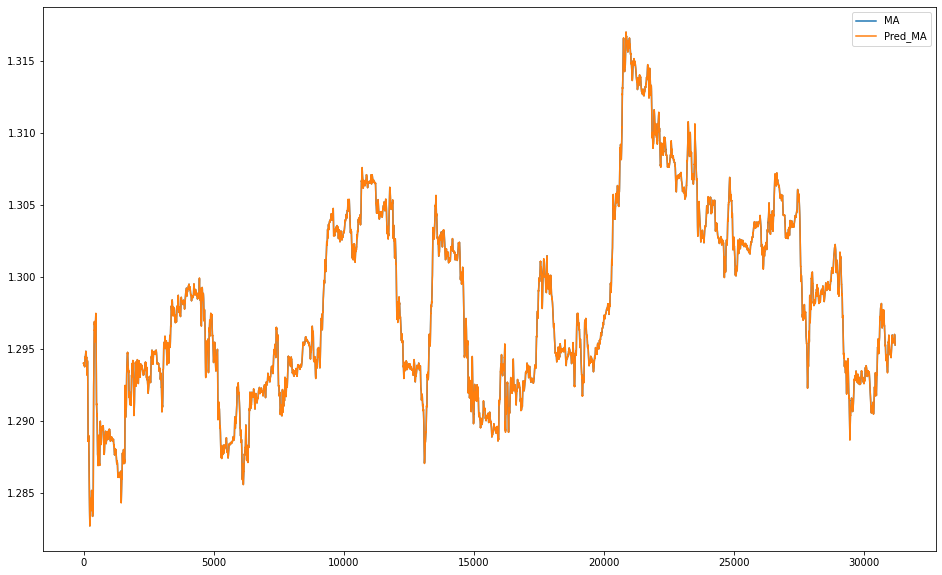

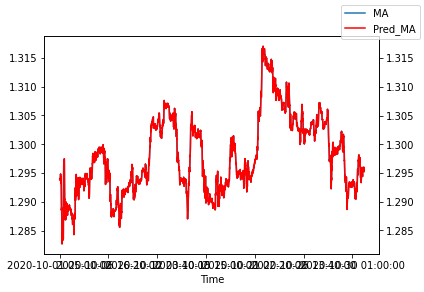

In [31]:
import matplotlib.pyplot as plt
df_for_plot.plot(figsize=(16, 10))
ax = df_for_plot.plot(x="Time", y="MA", legend=False)
ax2 = ax.twinx()
df_for_plot.plot(x="Time", y="Pred_MA", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()


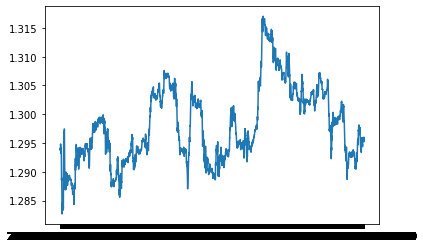

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(df_pred['Time'], df_pred['MA'])
plt.show()

In [ ]:

  # if sum(buying_flag) == 0:
  #   if next_val > base_val:
  #     buying_flag, selling_flag, holding_flag = flag_append(i,'buying', buying_flag, selling_flag, holding_flag,inventory)
  #   else:
  #     buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
  
  # else:
  #   if next_val > base_val:
  #     if buying_flag[i] == 0:
  #       if holding_flag[i] == 1:
  #         buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
  #       else:
  #         buying_flag, selling_flag, holding_flag = flag_append(i,'buying', buying_flag, selling_flag, holding_flag,inventory)
  #     elif buying_flag[i] == 1:
  #       buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)

  #   else:
  #     if selling_flag[i] == 0:
  #       if inventory[i] == 1:
  #         buying_flag, selling_flag, holding_flag = flag_append(i,'selling', buying_flag, selling_flag, holding_flag,inventory)
  #       else: 
  #         buying_flag, selling_flag, holding_flag = flag_append(i, 'holding', buying_flag, selling_flag, holding_flag,inventory)
  #     elif selling_flag[i] == 1:
  #       buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
      


In [213]:
hojin_test = df_test.dropna()
pred = hojin_test['Pred_MA']
buying_flag = [0]
selling_flag = [0]
holding_flag = [1]
inventory = [0]

def flag_append(i, flags, buying, selling, holding, inventory):

  if flags == 'buying':
    buying_flag.append(1)
    selling_flag.append(0)
    holding_flag.append(0)
    inventory.append(1)
  
  elif flags == 'selling':
    buying_flag.append(0)
    selling_flag.append(1)
    holding_flag.append(0)
    inventory.append(0)

  elif flags == 'holding':
    buying_flag.append(0)
    selling_flag.append(0)
    holding_flag.append(1)
    if inventory[i] == 0:
      inventory.append(0)
    else:
      inventory.append(1)

  return buying_flag, selling_flag, holding_flag

for i in range(len(pred)-1):

  base_val = pred.iloc[i]
  next_val = pred.iloc[i+1]

  if inventory[i] == 0:
    if next_val > base_val:
      buying_flag, selling_flag, holding_flag = flag_append(i,'buying', buying_flag, selling_flag, holding_flag,inventory)
    else:
      buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
  else:
    if next_val > base_val:
      buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
    else:
      buying_flag, selling_flag, holding_flag = flag_append(i,'selling', buying_flag, selling_flag, holding_flag,inventory)

buying_flag.pop(0)
selling_flag.pop(0)
holding_flag.pop(0)
inventory.pop(0)

buying_flag.pop(0)
selling_flag.pop(0)
holding_flag.pop(0)
inventory.pop(0)

if sum(buying_flag) == sum(selling_flag):
  buying_flag.append(0)
  selling_flag.append(0)
  holding_flag.append(1)
  inventory.append(0)

else:
  buying_flag.append(0)
  selling_flag.append(1)
  holding_flag.append(0)
  inventory.append(0)

buying_flag.append(0)
selling_flag.append(0)
holding_flag.append(1)
inventory.append(0)

hojin_test['buying'] = buying_flag
hojin_test['holding'] = holding_flag
hojin_test['selling'] = selling_flag
hojin_test['inventory'] = inventory

buying_df = hojin_test[hojin_test['buying']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "buying"})
selling_df = hojin_test[hojin_test['selling']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "selling"})

calculate_return_df = pd.concat([selling_df, buying_df], axis=1)
calculate_return_df['return'] = calculate_return_df['selling'] - calculate_return_df['buying'] +1
calculate_return_df['return'].cumprod().plot()



In [214]:
print(len(buying_flag), len(holding_flag), len(selling_flag), len(inventory))


960 960 960 960


In [215]:
hojin_test['buying'] = buying_flag
hojin_test['holding'] = holding_flag
hojin_test['selling'] = selling_flag
hojin_test['inventory'] = inventory

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [216]:
hojin_test[['buying', 'holding', 'selling', 'inventory']].sum()

buying        86
holding      788
selling       86
inventory    461
dtype: int64

In [217]:
hojin_test[['Time', 'Close', 'Pred_MA', 'buying', 'holding','selling', 'inventory']].head(30)

,Time,Close,Pred_MA,buying,holding,selling,inventory
30496,2020-10-30 05:00:00,1.29176,1.291966,0,1,0,0
30497,2020-10-30 05:01:00,1.29176,1.291940,0,1,0,0
30498,2020-10-30 05:02:00,1.29176,1.291912,0,1,0,0
30499,2020-10-30 05:03:00,1.29177,1.291880,0,1,0,0
30500,2020-10-30 05:04:00,1.29169,1.291860,0,1,0,0
30501,2020-10-30 05:05:00,1.29170,1.291840,0,1,0,0
30502,2020-10-30 05:06:00,1.29157,1.291817,0,1,0,0
30503,2020-10-30 05:07:00,1.29154,1.291789,0,1,0,0
30504,2020-10-30 05:08:00,1.29129,1.291760,0,1,0,0
30505,2020-10-30 05:09:00,1.29117,1.291723,0,1,0,0


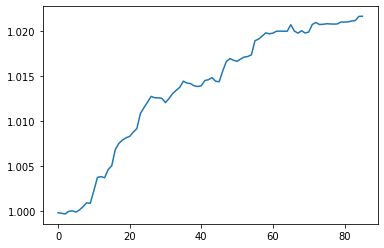

In [218]:
buying_df = hojin_test[hojin_test['buying']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "buying"})
selling_df = hojin_test[hojin_test['selling']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "selling"})

calculate_return_df = pd.concat([selling_df, buying_df], axis=1)
calculate_return_df['return'] = calculate_return_df['selling'] - calculate_return_df['buying'] +1
calculate_return_df['return'].cumprod().plot()


In [219]:
calculate_return_df

,selling,buying,return
0,1.29089,1.29112,0.99977
1,1.29074,1.29080,0.99994
2,1.29054,1.29061,0.99993
3,1.29096,1.29067,1.00029
4,1.29088,1.29083,1.00005
...,...,...,...
81,1.29544,1.29541,1.00003
82,1.29546,1.29537,1.00009
83,1.29552,1.29547,1.00005
84,1.29586,1.29541,1.00045


In [220]:
calculate_return_df['return'].cumprod()

0     0.999770
1     0.999710
2     0.999640
3     0.999930
4     0.999980
        ...   
81    1.021077
82    1.021169
83    1.021220
84    1.021680
85    1.021700
Name: return, Length: 86, dtype: float64